In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
from scipy.stats import mstats
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate2.xlsx")

In [4]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [5]:
df["elapsed"] = 2018 - df["year"]

In [6]:
df["distance"].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [7]:
dis_array = df["distance"].unique()

In [8]:
dis_array

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [9]:
dis_dict = {
    dis_array[0]: 10,
    dis_array[1]: 15,
    dis_array[2]: 5,
    dis_array[3]: 20,
    dis_array[4]: 30,
    dis_array[5]: np.nan,
}

In [10]:
df["distance2"] = df["distance"].apply(lambda x: dis_dict[x])

In [11]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,35,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,35,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,35,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0


In [12]:
df = df.dropna()

In [13]:
df2 = df[["space", "elapsed", "distance2", "value"]]

In [14]:
df2.head()

,space,elapsed,distance2,value
0,70,35,10.0,910
1,70,35,10.0,1120
2,70,35,10.0,1190
3,70,35,10.0,1190
4,70,35,10.0,1190


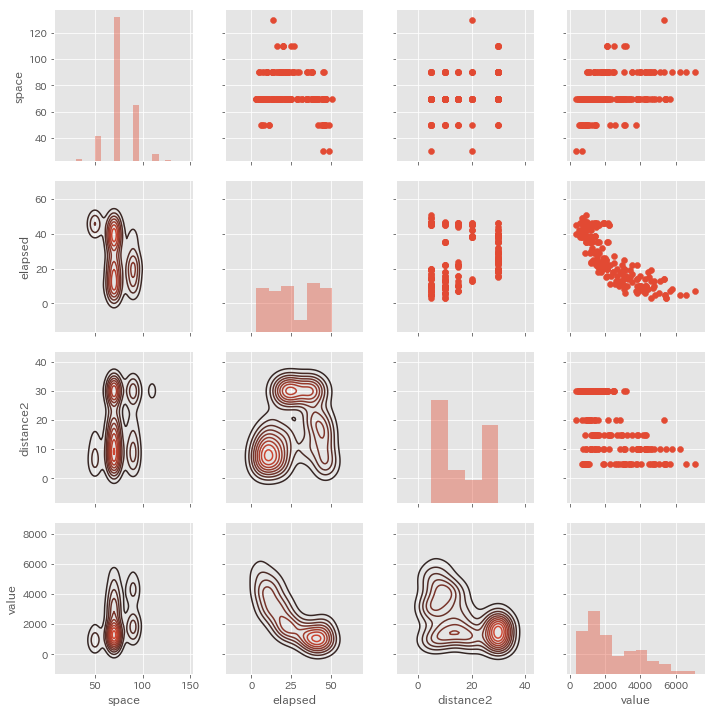

In [15]:
g = sns.PairGrid(df2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(plt.scatter)

In [20]:
stan_model = """
data {
    int N;
    real elapsed[N];
    real dis[N];
    real space[N];
    real Y[N];
}
parameters {
    real d;
    real s;
    real e;
    real b;
    real<lower=0> sigma;
}
model {
    for (n in 1:N) {
        Y[n] ~ normal(e * elapsed[n] + d * dis[n] + s * space[n] + b, sigma);
    }
}
"""

In [21]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_876e6512af672e1360e0c9f71c1b8c46 NOW.
C:\Users\s.takai\Anaconda3\envs\tf\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\SF871~1.TAK\AppData\Local\Temp\tmp33hrj1sf\stanfit4anon_model_876e6512af672e1360e0c9f71c1b8c46_87247098216598369.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [22]:
stan_data = {
    "N": df.shape[0],
    "elapsed": df["elapsed"],
    "dis": df["distance2"],
    "space": df["space"],
    "Y": df["value"],
}

In [23]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=4, seed=123)

In [24]:
fit

Inference for Stan model: anon_model_876e6512af672e1360e0c9f71c1b8c46.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.56    0.08   4.98 -67.42 -60.88 -57.49 -54.21 -47.86   3857    1.0
s      24.62    0.07   3.59  17.44  22.19  24.55  26.99  31.65   2774    1.0
e     -67.68    0.06   3.74 -75.06 -70.21 -67.72 -65.17 -60.36   3392    1.0
b     3299.3    5.71 294.14 2734.2 3100.8 3304.8 3497.2 3885.9   2653    1.0
sigma 636.87    0.44  31.74 577.41 615.03 635.19 657.69 701.32   5111    1.0
lp__   -1363    0.03   1.54  -1367  -1364  -1363  -1362  -1361   2142    1.0

Samples were drawn using NUTS at Sat Feb 23 23:24:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

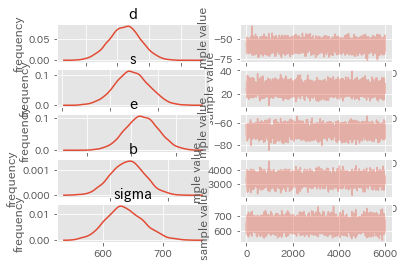

In [25]:
fig = fit.plot()